# Problèmes Inverses - DM1

## Poisson Thomas

---

### Régression linéaire - inférence des paramètres physiquesà partir des observations

Nous considérons comme problème la trajectoire d'une balle, projetée verticalement à partir d'une position $m_1$, à une vitesse initiale $m_2$, et subit une force de gravitation $m_3$.

Les données sont les hauteurs de la balle $h_i$ mesurées à différents instants $t_i$.

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from IPython.display import display

def show_data(tt, hh) :
    #affiche les données position hh en fonction du temps tt
    plt.plot(tt, hh, label="h(t)")
    plt.xlabel('Temps t')
    plt.ylabel('Position h')
    plt.legend()
    plt.show()

## Mise en équation du du système linéaire

on a par les lois de Newton que la relation entre le temps et la position s'écrivent sous la forme :
$$
y(t) = m_1 + m_2 t - \frac{1}{2} m_3 t^2
$$

L'équation linéaire du système à résoudre pour obtenir les paramètres s'écrit sous la forme :
$
d = Gm
$
où
$$
G =
\begin{bmatrix}
    1 ~ t_0 ~ t_0^2\\
    ~ ~ ...\\
    1 ~ t_n ~ t_n^2
\end{bmatrix}
\\
\\
d=(y_i)_{i=1,...,n} \\
\\
m=
\begin{bmatrix}
   m_1 \\
   m_2 \\
   - \frac{1}{2} m_3
\end{bmatrix}
$$

l'équation et la résolution est mise en place par le code suivant :

In [67]:
def least_squared_regression(x, d, Kmax, std=1):
    #résoud le problème inverse linéaire avec la méthode des moindres carrés pour Kmax paramètres
    cst = [1, 1, (-1/2)]
    G = np.array([cst[i] * x**i for i in range(0,Kmax)]).T
    C = (1/std**2) * np.eye(len(d)) #on suppose que toutes les données ont le même écart type
    m = inv( G.T @ inv(C) @ G ) @ G.T @ inv(C) @ d
    return m, G, C

## Définition des fonctions utilisées pour le calcul et l'interprétation du modèle obtenu

In [74]:
def show_modeled_data(tt, hh, modeled_hh) :
    #affiche les données position hh en fonction du temps tt
    plt.plot(tt, hh,'+', label="h(t)")
    plt.plot(tt, modeled_hh, label="h_modeled(t)")
    plt.xlabel('Temps t')
    plt.ylabel('Position h')
    plt.legend()
    plt.show()

def corr_matrix(cov_matrix) :
    #calcul de la matrice de correlation a partir de la matrice de covariance
    dim1, dim2 = cov_matrix.shape
    corr_matrix = np.zeros([dim1, dim2])
    for i in range(dim1):
        for j in range(dim2):
            corr_matrix[i][j] = cov_matrix [i][j] / (np.sqrt(cov_matrix [i][i]) * np.sqrt(cov_matrix [j][j]))
    return corr_matrix

def show_misfit(data, data_err, std=1):
    #misfit des moindres carrés
    misfit = (1/len(data)) * sum((data - data_err)**2 / std**2)
    print(f'misfit : {misfit:e}')
    return misfit

def show_residual_hist(tt, hh, modeled_hh):
    #observation de la différence data_modeled et data_measured en histogramme
    plt.hist(hh - modeled_hh, bins = 15, label="residual") #range = [np.min(tt), np.max(tt)]
    #plt.xlabel('Temps t')
    #plt.ylabel('Position h')
    plt.legend()
    plt.show()

def data_analysis(tt, hh, modeled_hh, m, G, Cd, std_val) :
    #Analyse du modele

    #show_data(tt, hh) #observation des données
    show_modeled_data(tt, hh, modeled_hh) #observation des données calculées directement à partir du modèle

    print('parametres du modele : ', m)
    #calcul des matrices de covariance et de corrélation, intervalle de confiance
    Cm = inv(G.T @ inv(Cd) @ G)
    print('matrice de covar. : \n', Cm)
    Rm = corr_matrix(Cm)
    print('matrice de correl. : \n', Rm)
    
    #valeurs de CHI
    X = [3.96, 5.99, 7.81]
    larg_interval = X[2] * np.sqrt(Cm.diagonal())
    confd_interval = np.array([m - larg_interval, m+larg_interval])
    for i in range(len(m)):
        print(f"intervalles de confiance, paramètre m_{i+1}: {confd_interval[:,i]}")

    show_misfit(hh, modeled_hh, std=std_val) #misfit des moindres carrés
    show_residual_hist(tt, hh, modeled_hh) #observation des residus

## Analyse du modèle avec données initiales

Calcul et analyse d'un premier modèle, avec l'intégralité des données d'origines, et une valeur de l'écart-type choisie arbitrairement et pour l'instant égale à 1.

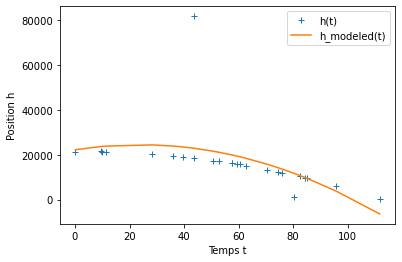

parametres du modele :  [2.21893717e+04 1.89436972e+02 7.97967358e+00]
matrice de covar. : 
 [[ 3.65417688e-01 -1.20937708e-02 -1.78385706e-04]
 [-1.20937708e-02  5.56665997e-04  9.70865137e-06]
 [-1.78385706e-04  9.70865137e-06  1.86218014e-07]]
matrice de correl. : 
 [[ 1.         -0.84794875 -0.68383988]
 [-0.84794875  1.          0.95356591]
 [-0.68383988  0.95356591  1.        ]]
intervalles de confiance, paramètre m_1: [22184.65056969 22194.09282659]
intervalles de confiance, paramètre m_2: [189.25270463 189.62123932]
intervalles de confiance, paramètre m_3: [7.97630333 7.98304383]
misfit : 1.528268e+08


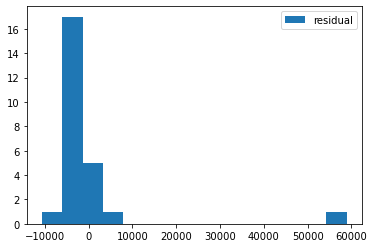

In [75]:
def main_original_data() :
    #lecture des données à partir du csv
    tt, hh = np.loadtxt('data.csv', skiprows=1, unpack=True)
    
    #show_data(tt, hh)
    std_val = 1
    m, G, Cd = least_squared_regression(tt, hh, Kmax=3, std=std_val) #calcul du modele (donnees d'origine) au moindres carrés à 3 degrés de liberté
    modeled_hh = [m[0] + m[1] * t -(0.5)*m[2] * t**2 for t in tt] # G @ m #
    data_analysis(tt, hh, modeled_hh, m, G, Cd, std_val)
main_original_data()

On observe que le modèle n'approxime pas bien nos données. De plus, la valeur du misfit est élevée. Un bon misfit est de l'ordre de $\frac{N - M}{N}$, avec $N$ le nombre de données et $M$ le nombre de paramètres du modèle.

En regardant l'histograme des résidus, on n'observe pas une **courbe de Gauss** : on en déduit donc que nos données comportent des **valeurs anormales**, et ne sont pas bruités selon une loi normale. Or, pour obtenir une bonne approximation au sens des moindres carrés, cette hypothèse est nécessaire.
On décide donc d'enlever certaines valeurs, celles dont le carré est le plus éloigné du modèle. On choisit d'en enlever 2, suite à l'observation des données et du modèle. Les résultats suivant sont obtenus avec des **données filtrées**.

## Filtrage des données

On choisit d'enlever les données pour lesquelles le carré de l'écart entre données observées et données modélisées est maximal. En effet ce sont les données qui diffèrent le plus de notre modèle au sens des **moindres carrés**.

ecart type choisi : 1


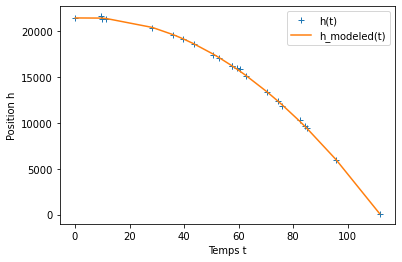

parametres du modele :  [2.14010489e+04 1.61263675e+01 3.70356829e+00]
matrice de covar. : 
 [[ 3.66484171e-01 -1.21149813e-02 -1.77914279e-04]
 [-1.21149813e-02  5.68119127e-04  9.92853176e-06]
 [-1.77914279e-04  9.92853176e-06  1.91190888e-07]]
matrice de correl. : 
 [[ 1.        -0.8396058 -0.6721243]
 [-0.8396058  1.         0.9526464]
 [-0.6721243  0.9526464  1.       ]]
intervalles de confiance, paramètre m_1: [21396.32086546 21405.77689108]
intervalles de confiance, paramètre m_2: [15.94021417 16.31252077]
intervalles de confiance, paramètre m_3: [3.70015334 3.70698324]
misfit : 7.978585e+03


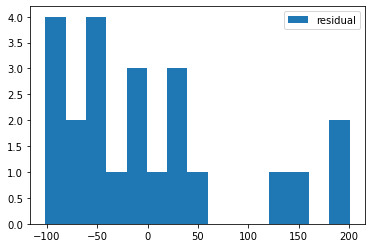

In [76]:
def data_removal(tt, hh, modeled_hh) :
    idx_to_remove = np.argmax(np.abs(hh - modeled_hh)**2)
    tt = np.delete(tt, idx_to_remove)
    hh = np.delete(hh, idx_to_remove)
    return tt, hh
    
def main_data_removal() :
    #lecture des données à partir du csv
    tt, hh = np.loadtxt('data.csv', skiprows=1, unpack=True)
    
    std_val = 1
    print(f'ecart type choisi : {std_val}')
    m, G, Cd = least_squared_regression(tt, hh, Kmax=3, std=std_val) #calcul du modele (donnees d'origine) au moindres carrés à 3 degrés de liberté
    modeled_hh = [m[0] + m[1] * t -(0.5)*m[2] * t**2 for t in tt] # G @ m #

    nb_val_removed = 2 #chercher la valeur optimale, 2 a priori
    for i in range(nb_val_removed) :
        tt, hh = data_removal(tt, hh, modeled_hh)
        std = 1
        m, G, Cd = least_squared_regression(tt, hh, Kmax=3, std=std_val) #calcul du modele (donnees modifiees) au moindres carrés à 3 degrés de liberté
        modeled_hh = [m[0] + m[1] * t -(0.5)*m[2] * t**2 for t in tt] # G @ m #
    data_analysis(tt, hh, modeled_hh, m, G, Cd, std_val)

main_data_removal()

Après filtrage des données, on observe une modification du modèle, une diminution du misfit, et un histogramme des résidus plus groupé. Cela nous conforte dans notre choix d'élimination des données anormales. On voit de plus, graphiquement, que la courbe représentant la hauteur de la balle au cours du temps est plus lisse, et plus proche de celle obtenue par le modèle.


## Impact de l'écart type sur le misfit
On choisit ensuite d'observer l'impact du **choix de l'écart type** sur les données observées.

In [77]:
def main_std_test ():
    std_list=[0.5, 1, 800]
    for std_val in std_list :
        #test pour differents ecart type
        tt, hh = np.loadtxt('data.csv', skiprows=1, unpack=True)
        
        print(f'ecart type choisi : {std_val}')
        m, G, Cd = least_squared_regression(tt, hh, Kmax=3, std=std_val) #calcul du modele (donnees d'origine) au moindres carrés à 3 degrés de liberté
        modeled_hh = [m[0] + m[1] * t -(0.5)*m[2] * t**2 for t in tt] # G @ m #

        nb_val_removed = 2 #chercher la valeur optimale, 2 a priori
        for i in range(nb_val_removed) :
            tt, hh = data_removal(tt, hh, modeled_hh)
            m, G, Cd = least_squared_regression(tt, hh, Kmax=3, std=std_val) #calcul du modele (donnees modifiees) au moindres carrés à 3 degrés de liberté
            modeled_hh = [m[0] + m[1] * t -(0.5)*m[2] * t**2 for t in tt] # G @ m #
        show_misfit(hh, modeled_hh, std=std_val) #misfit des moindres carrés
        #data_analysis(tt, hh, modeled_hh, m, G, Cd, std_val)
        print('\n')

main_std_test()

ecart type choisi : 0.5
misfit : 3.191434e+04


ecart type choisi : 1
misfit : 7.978585e+03


ecart type choisi : 800
misfit : 1.246654e-02




On voit que le choix de l'écart type impacte la valeur du misfit obtenue pour le modèle. Le résultat théorique optimal du misfit est de 1. L'écart type de 0.5 est donc trop faible et celui de 800 trop élevé.

## Calcul a posteriori de l'écart type des données observés


In [78]:
def main_std_opt ():
    #test pour differents ecart type
    tt, hh = np.loadtxt('data.csv', skiprows=1, unpack=True)
    
    std_val=1
    m, G, Cd = least_squared_regression(tt, hh, Kmax=3, std=std_val) #calcul du modele (donnees d'origine) au moindres carrés à 3 degrés de liberté
    modeled_hh = [m[0] + m[1] * t -(0.5)*m[2] * t**2 for t in tt] # G @ m #

    nb_val_removed = 2 #chercher la valeur optimale, 2 a priori
    for i in range(nb_val_removed) :
        tt, hh = data_removal(tt, hh, modeled_hh)
        m, G, Cd = least_squared_regression(tt, hh, Kmax=3, std=std_val) #calcul du modele (donnees modifiees) au moindres carrés à 3 degrés de liberté
        modeled_hh = [m[0] + m[1] * t -(0.5)*m[2] * t**2 for t in tt] # G @ m #
    std_val = np.sqrt(1/(len(hh)-len(m)) * np.sum((hh-modeled_hh)**2)) #np.std(np.abs(hh - modeled_hh))
    print(f"valeur de l'ecart type optimal calcule : {std_val}")
    #data_analysis(tt, hh, modeled_hh, m, G, Cd, std_val)
    
    #show_residual_hist(tt, hh, modeled_hh) #observation des residus
    #show_misfit(hh, modeled_hh, std=std_val) #misfit des moindres carrés

main_std_opt()

valeur de l'ecart type optimal calcule : 95.78816595057503


Nous retrouvons l'écart type sur les données initiales en calculant la variance du système modèle/mesure, à $N - M$ degrés de liberté. (avec $N$ le nombre de données et $M$ le nombre de paramètres du modèle).

## Tracé des ellipses de confiance

On calcule et on projette en 2D les ellipses de confiance à 95%, pour chaque combinaison des paramètres du modèle.

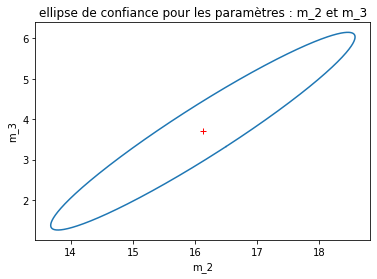

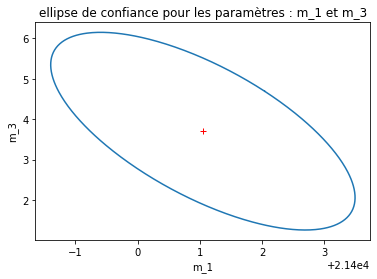

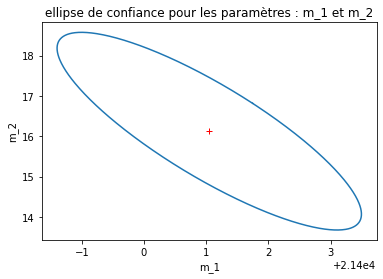

In [142]:
def show_ellipses(m, Rm_proj, idx):
    lam, u = np.linalg.eig(inv(Rm_proj))
    theta = np.arange(0, 2*np.pi, 0.01)
    delta = np.sqrt(5.99) #delta chi-squared for 95% confidence region, with 2 degrees of freedom
    
    elx=(delta/np.sqrt(lam[0])) * u[0,0] * np.cos(theta) + (delta/np.sqrt(lam[1])) * u[0,1] * np.sin(theta)
    ely=(delta/np.sqrt(lam[0])) * u[1,0] * np.cos(theta) + (delta/np.sqrt(lam[1])) * u[1,1] * np.sin(theta)
    plt.plot(m[idx][0]+elx, m[idx[1]]+ely)
    plt.plot(m[idx][0], m[idx[1]], 'r+')
    plt.xlabel(f'm_{idx[0]+1}')
    plt.ylabel(f'm_{idx[1]+1}')
    plt.title(f'ellipse de confiance pour les paramètres : m_{idx[0]+1} et m_{idx[1]+1}')
    plt.show()
    return None
    
def main_ellipses ():
    #test pour differents ecart type
    tt, hh = np.loadtxt('data.csv', skiprows=1, unpack=True)
    
    std_val=1
    m, G, Cd = least_squared_regression(tt, hh, Kmax=3, std=std_val) #calcul du modele (donnees d'origine) au moindres carrés à 3 degrés de liberté
    modeled_hh = [m[0] + m[1] * t -(0.5)*m[2] * t**2 for t in tt] # G @ m #

    nb_val_removed = 2 #chercher la valeur optimale, 2 a priori
    for i in range(nb_val_removed) :
        tt, hh = data_removal(tt, hh, modeled_hh)
        m, G, Cd = least_squared_regression(tt, hh, Kmax=3, std=std_val) #calcul du modele (donnees modifiees) au moindres carrés à 3 degrés de liberté
        modeled_hh = [m[0] + m[1] * t -(0.5)*m[2] * t**2 for t in tt]
    Cm = inv(G.T @ inv(Cd) @ G)
    Rm = corr_matrix(Cm)
    for i in range(len(m)) :
        idx = [j for j in range(len(m)) if j!=i]
        Rm_proj = Rm[idx,:][:,idx]
        show_ellipses(m, Rm_proj, idx)

main_ellipses()

## Conclusion générale

On déduit du modèle obtenu la constante de gravitation de la planète sur laquelle est effectuée le tir : celle-ci vaut $3.70 m.s^{-2}$ 
La planète du système solaire ayant la constante la plus proche est **Mars**.